In [1]:
import datetime
import requests
import pandas
import unlzw3
import os
from pathlib import Path
from io import StringIO 
from datetime import date
from astropy.io import fits
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from glob import glob as g
import numpy as np
%matplotlib inline

In [2]:
today_dt = date.today()
if datetime.datetime.now().hour < 10: today_dt = today_dt - datetime.timedelta(days=1)
yesterday_dt = today_dt - datetime.timedelta(days=1)
today = today_dt.strftime(format="%Y %m %d").replace(" ","%20")
yesterday = yesterday_dt.strftime(format="%Y %m %d").replace(" ","%20")
# more dates can be added or subtracted
files_dict = {
  'now': {
    'date':today, 'filename': 'FEROS_TODAY'
  }, 
  'yesterday': {
    'date':yesterday, 'filename': 'FEROS_YESTERDAY'
  }, 
  'ref1': {
    'date':"2021%2011%2006",'filename':'FEROS_REFERENCE_1'
  },
  'ref2': {
    'date':"2018%2005%2010",'filename':'FEROS_REFERENCE_2'
  }
}
line_slices = [
  [2796,2808,412,448],
  [1580,1595,1430,1470],
  [2153,2164,966,1000]
]
line_data = []
colours = "kbgrcmy"
vmin=260;vmax=370
keys = list(files_dict.keys())
fits_files = g("*.fits")
dates = []
for f in fits_files:
  h = fits.open(f)
  file_date = h[0].header['DATE'].split('T')[0]
  file_date = file_date.replace("-","%20")
  dates.append(file_date)

Analysing FEROS_TODAY
Analysing FEROS_YESTERDAY
Analysing FEROS_REFERENCE_1
Analysing FEROS_REFERENCE_2


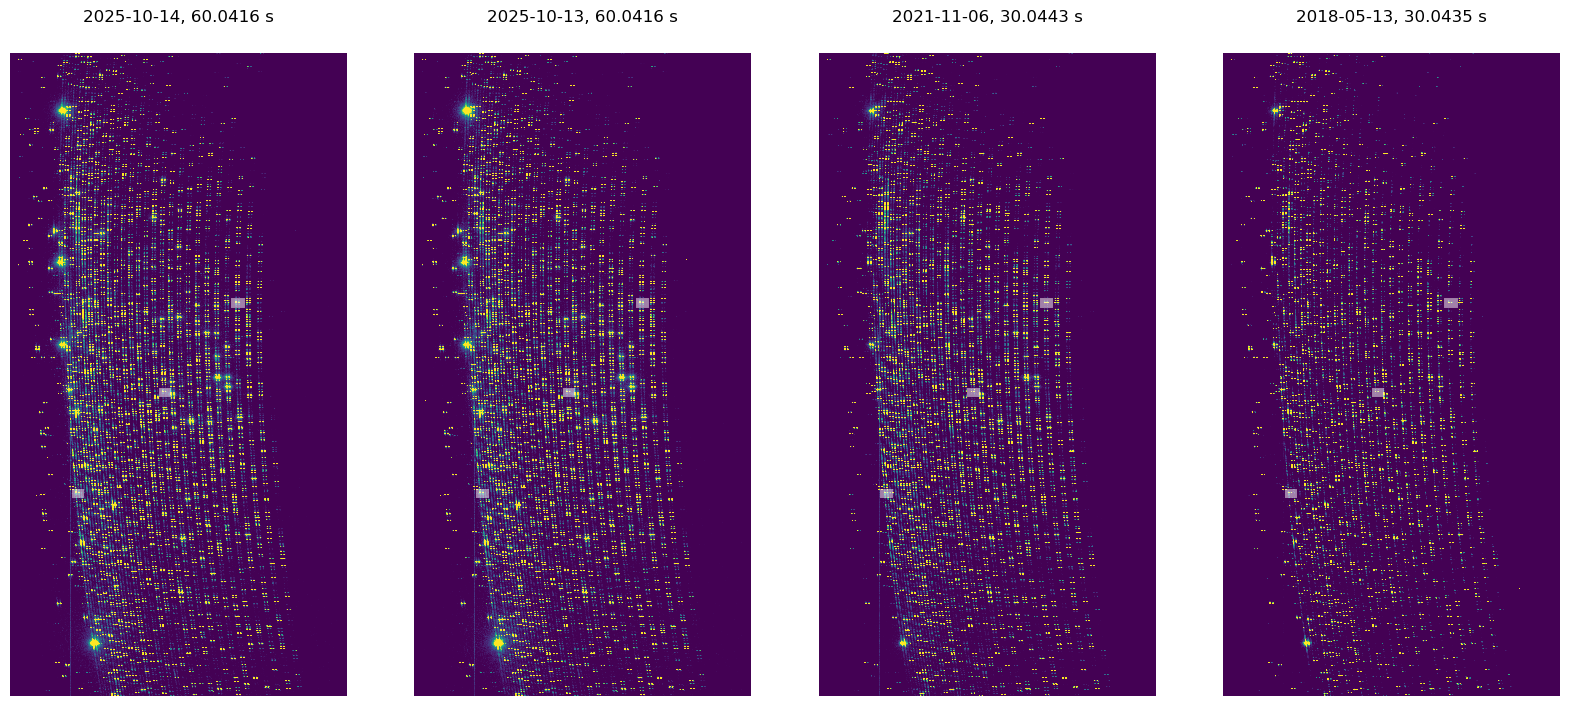

In [3]:
fig,ax=plt.subplots(nrows=1,ncols=len(keys),figsize=(20, 20))
for a,k in zip(ax,keys):
  filename = files_dict[k]["filename"]
  file_date = files_dict[k]["date"]
  filename_zip = filename+".Z"
  filename_fits = filename+".fits"
  print(f"Analysing {filename}")
 # step one: query ESO on each date
  #if not files_dict[k].get("exists"):
  if file_date not in dates:
    print(f"{filename} doesn't exist, downloading and creating")
    url = f"""https://archive.eso.org/wdb/wdb/eso/eso_archive_main/query?wdbo=csv&max_rows_returned=200&instrument=FEROS
&tab_object=on&target=&resolver=simbad&ra=&dec=&box=00%2010%2000&degrees_or_hours=hours&tab_target_coord=on
&format=SexaHour&wdb_input_file=&tab_night=on&night={files_dict[k]['date']}&stime=&starttime=12&etime=&endtime=12
&tab_prog_id=on&prog_id=&gto=&pi_coi=&obs_mode=&title=&image[]=GROND&image[]=WFI&spectrum[]=FEROS
&tab_dp_cat=on&dp_cat=CALIB&tab_dp_type=on&dp_type=WAVE&dp_type_user=&tab_dp_tech=on&dp_tech=
&dp_tech_user=&tab_dp_id=on&dp_id=&origfile=&tab_rel_date=on&rel_date=&obs_name=&ob_id=&tab_tpl_start=on
&tpl_start=&tab_tpl_id=on&tpl_id=&tab_exptime=on&exptime=&tab_filter_path=on&filter_path=&tab_wavelength_input=on
&wavelength_input=&tab_fwhm_input=on&fwhm_input=&gris_path=&grat_path=&slit_path=&tab_instrument=on
&tab_tel_airm_start=on&tab_stat_instrument=on&tab_ambient=on&tab_stat_exptime=on&tab_HDR=on&tab_mjd_obs=on
&aladin_colour=aladin_instrument&order=tpl_start&"""
    _response = requests.get(url)
    response = _response.text
    observed_data = pandas.read_table(StringIO(response),sep=",")
 # step two: get last file with  40s for old files, 60s with new
    if k in ["now","yesterday"]: 
      tmin=59;tmax=61
    else:
      tmin=29;tmax=31
    observed_data = observed_data[observed_data["Exptime"]>=tmin]
    observed_data = observed_data[observed_data["Exptime"]<=tmax]
    url = 'https://dataportal.eso.org/dataPortal/file/' + observed_data.iloc[-1]["Dataset ID"]
 # step three: download, unzip and create file
    urlretrieve(url, filename=filename_zip)
    extracted_data = unlzw3.unlzw(Path(filename_zip))
    if os.path.exists(filename_fits): os.remove(filename_fits)
    file_now = open(filename_fits,"wb")
    file_now.write(extracted_data)
    file_now.close()
 # step four: extract and plot data 
  hdu = fits.open(filename_fits,ignore_missing_simple=True)
  header = hdu[0].header
  data = hdu[0].data
  a.matshow(data,vmin=vmin,vmax=vmax)
  lines_data = []
  for l in line_slices:
    lines_data.append(data[l[0]:l[1],l[2]:l[3]])
  line_data.append(lines_data)
  a.set_title(f"{(header['DATE']).split('T')[0]}, {header['EXPTIME']} s")
  for ls in line_slices:
    a.add_patch(Rectangle(
    (ls[2],ls[0]), ls[3]-ls[2], ls[1]-ls[0], 
    linewidth=5,
    edgecolor='w',
    facecolor="none",
    alpha=0.5
     ))
  a.set_axis_off()
plt.savefig("wavelenght_comparison_fullspec.png",dpi=300)

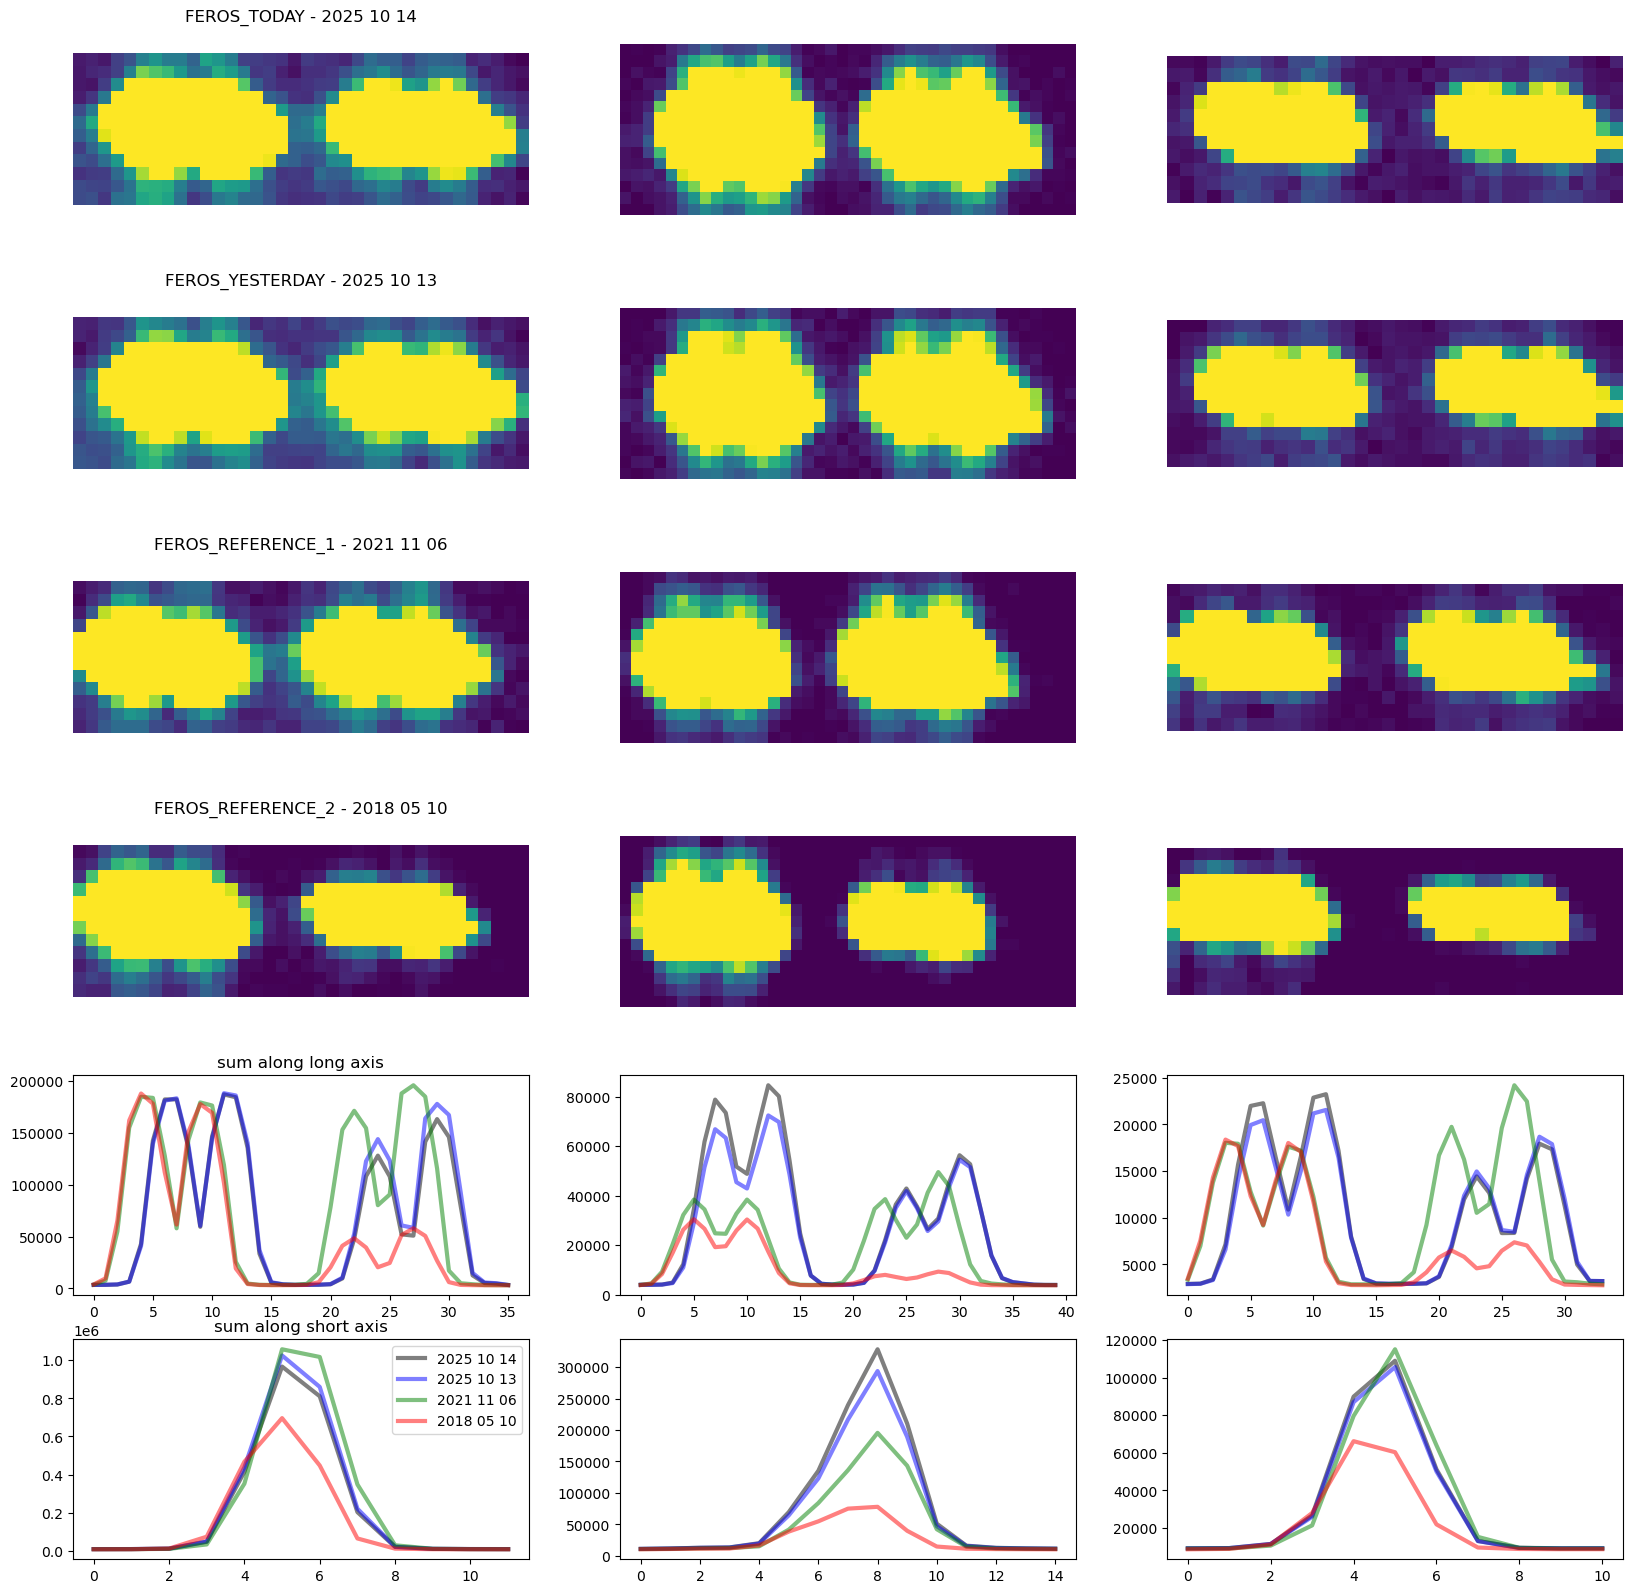

In [4]:
fig,ax = plt.subplots(ncols = len(line_slices),nrows = len(line_data)+2,figsize=(20,20))
for i,f in enumerate(line_data):
  for j,l in enumerate(f):
    ax[i,j].matshow(l,vmin=vmin,vmax=vmax)
    ax[i,j].set_axis_off()
    ax[len(line_data),j].plot(np.sum(l,axis=0),c=colours[i],alpha=0.5,lw=3)
    ax[len(line_data)+1,j].plot(np.sum(l,axis=1),c=colours[i],label = (files_dict[keys[i]]["date"]).replace("%20"," "),alpha=0.5,lw=3)  
  ax[i,0].set_title(files_dict[keys[i]]["filename"]+" - "+(files_dict[keys[i]]["date"]).replace("%20"," "))
  ax[len(line_data),0].set_title("sum along long axis")
  ax[len(line_data)+1,0].set_title("sum along short axis")
ax[len(line_data)+1][0].legend()
plt.savefig("wavelenght_comparison.png",dpi=300)